<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [3]:
!pip install word2vec

     |████████████████████████████████| 42 kB 586 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=3af45a0303e7a6fc2044b597faf915556da09a502dfc62d4888e845a70c929ca
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [4]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [5]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-04-06 12:43:08--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.15MB/s    in 14s     

2022-04-06 12:43:22 (2.14 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [84]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/how_to_podacst'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-04-06 14:45:58--  https://raw.githubusercontent.com/grace-boop/podcast/main/how_to_podacst
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14559 (14K) [text/plain]
Saving to: ‘how_to_podacst’

how_to_podacst      100%[===================>]  14.22K  --.-KB/s    in 0s      

2022-04-06 14:45:58 (69.1 MB/s) - ‘how_to_podacst’ saved [14559/14559]



## Train wordvectors

In [7]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [8]:
model.save(wrdvec_path)

In [9]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [10]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.1 MB/s 


In [11]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [12]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [38]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 38.43
195 sentences, 17 segments, avg 11.47 sentences per segment
optimal score 5289.23, greedy score 5281.85
[5289.232001795918, 5281.848180096586]
(5289.232001795918, 5281.848180096586)
ratio of scores 1.0014


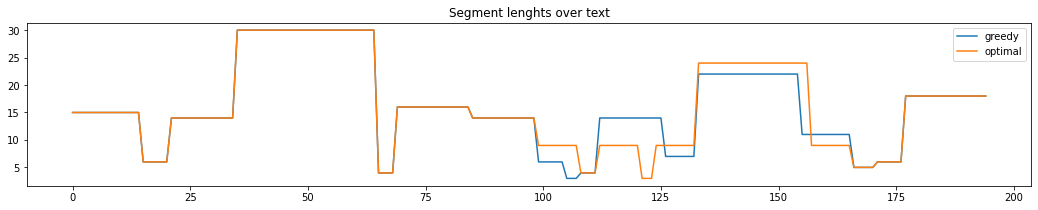

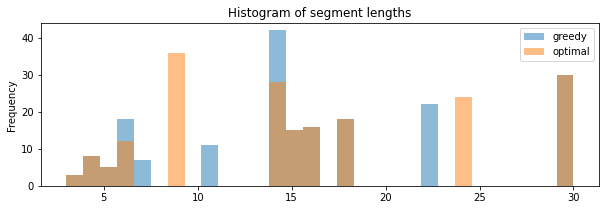

In [85]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [86]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

["You've been thinking about starting your podcast. ", "You've been obsessing about the idea for months and years. ", "Yeah, or you've been procrastinating it or you're overwhelmed by all the different technical stuff that goes into starting a podcast. ", "Well in this video we're going to show you the four different ways. ", 'You can start your podcast. ', "This year's here. ", 'Hey, welcome to the Pod, sounds cool. ', "I'm Studio. ", "Steve and I'm Veronica and we're podcast coaches podcast producers and we've helped dozens of clients and huh.Words of students to get some really amazing results, their podcast, and we want to do the same for you. ", 'In this video. ', "We're going to show you the four different ways. ", 'You can start your podcasts from the very basic to a professional level. ', "And we're going to show you also the pros and cons of each option. ", "Yeah, and by the end of this video, you're going to know everything you need to know in order to start your podcast toda

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 48.1 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.5 MB 47.3 MB/s 
     |████████████████████████████████| 136 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 212 kB 18.4 MB/s 
     |████████████████████████████████| 127 kB 48.5 MB/s 
     |████████████████████████████████| 271 kB 6.4 MB/s 
     |████████████████████████████████| 144 kB 52.4 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling 

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.0 MB/s 


### 處理輸入

In [87]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [20]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [21]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [47]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [104]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)


### 顯示結果

In [105]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Four Different Ways You Can Start Your Podcast'}
<class 'dict'>
{'generated_text': 'Podcasting - How to Create a Podcast'}
<class 'dict'>
{'generated_text': 'Podcast Host - Podcast Host - Podcast Host - Podcast'}
<class 'dict'>
{'generated_text': 'Podcast Coaching - How to Start Your Podcast'}
<class 'dict'>
{'generated_text': 'Podcasting - Podcasting - Podcasting Apps'}
<class 'dict'>
{'generated_text': 'Podcasting - The Best Podcasting Solution For Beginners'}
<class 'dict'>
{'generated_text': 'Podcasting - The Best Option For Your Computer and a USB Microphone'}
<class 'dict'>
{'generated_text': 'The Best Podcasting Apps For Free'}
<class 'dict'>
{'generated_text': "Reaper - She's Going to Plug It Directly Into the Cuter"}
<class 'dict'>
{'generated_text': 'How to Edit Your Own Podcast'}
<class 'dict'>
{'generated_text': 'Reaper Training - Free 40 Minute Training'}
<class 'dict'>
{'generated_text': 'Podcasting - The Basics'}
<class 'dict'>
{'generated_text': 

In [106]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Four Different Ways You Can Start Your Podcast']
['The Four Different Ways You Can Start Your Podcast']
<class 'str'>
['Podcasting', '-', 'How to Create a Podcast']
['Podcasting', '-', 'How to Create a Podcast']
<class 'str'>
['Podcast Host', '-', 'Podcast Host', '-', 'Podcast Host', '-', 'Podcast']
['Podcast Host', '-', ' ', ' ', ' ', ' ', 'Podcast']
<class 'str'>
['Podcast Coaching', '-', 'How to Start Your Podcast']
['Podcast Coaching', '-', 'How to Start Your Podcast']
<class 'str'>
['Podcasting', '-', 'Podcasting', '-', 'Podcasting Apps']
['Podcasting', '-', ' ', ' ', 'Podcasting Apps']
<class 'str'>
['Podcasting', '-', 'The Best Podcasting Solution For Beginners']
['Podcasting', '-', 'The Best Podcasting Solution For Beginners']
<class 'str'>
['Podcasting', '-', 'The Best Option For Your Computer and a USB Microphone']
['Podcasting', '-', 'The Best Option For Your Computer and a USB Microphone']
<class 'str'>
['The Best Podcasting Apps For Free']
['The Best Podcasting Apps 

In [103]:
for headline_string in headlines_string:
  print(headline_string)

 The Four Different Ways You Can Start Your Podcast
 Podcasting - How to Create a Podcast
 Podcast Host - Podcast
 Podcast Coaching - How to Start Your Podcast
 Podcasting - Podcasting Apps
 Podcasting - The Best Podcasting Solution For Beginners
 Podcasting - The Best Option For Your Computer and a USB Microphone
 The Best Podcasting Apps For Free
 Reaper - She's Going to Plug It Directly Into the Cuter
 How to Edit Your Own Podcast
 Reaper Training - Free 40 Minute Training
 Podcasting - The Basics
 Podcasting - The Scarlett to I2
 Podcasting - The Ultimate Content Repurposing for Your Podcast
 How to Repurpose Your Podcast
 Podcasting 
 Podcasting - The Smart Way to Launch Your Podcast


In [37]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']
